In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm

Let's read in the data again, and apply the same cleaning steps as we did in the EDA:

In [2]:
df = pd.read_csv('Data/openpowerlifting.csv')

In [3]:
numeric_columns = ['Age', 'BodyweightKg', 'Squat4Kg', 'BestSquatKg', 'Bench4Kg', 'BestBenchKg',
               'Deadlift4Kg', 'BestDeadliftKg', 'TotalKg', 'Wilks']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
df[numeric_columns] = df[numeric_columns].abs()
keep_cols = ['MeetID', 'Name', 'Sex', 'Equipment', 'BodyweightKg', 'WeightClassKg',
            'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg', 'Place', 'Wilks']
df = df[keep_cols]
df = df.dropna()

Let's do the same method of getting the best Wilks per lifter per weight class:

In [4]:
best_df = df.groupby(['Name', 'WeightClassKg']).max()

Let's examine the combined distribution for Wilks - assume it can be modelled as a normal distribution (as a variable based off bodyweight and weight lifted, this is an appropriate choice - there is no risk of "Black Swan events").

Assuming that the distribution for men and women is the same then we can take the combined distribution's mean and standard deviation as priors for the separate distributions for men and women.

In [5]:
m_wilks = best_df[best_df.Sex=='M'].Wilks.values
f_wilks = best_df[best_df.Sex=='F'].Wilks.values
wilks_tot = np.concatenate((m_wilks, f_wilks))

In [6]:
normal = stats.norm
prior_mu = np.mean(wilks_tot)
prior_std = np.std(wilks_tot)
print(prior_mu, prior_std)

343.91882074 76.6483176594


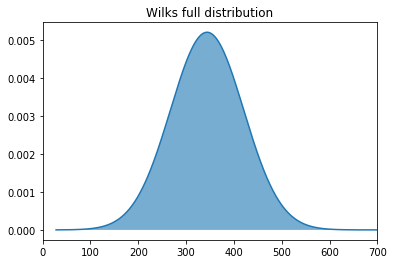

In [7]:
x = np.linspace(np.min(wilks_tot), np.max(wilks_tot), 1000)
y = normal.pdf(x, prior_mu, scale = prior_std)
plt.plot(x, y)
plt.fill_between(x, 0, y, linewidth=2, alpha = 0.6)
plt.title('Wilks full distribution')
plt.xlim(0, 700)
plt.show()

Now let's model the distribution of Wilks scores for men and women as separate normal distributions. We'll model the mean and standard deviation for each as random variables themselves, described by separate normal distributions. We'll use PyMC3, a module for probabilistic programming and Bayseian inference, to do this.

In [8]:
with pm.Model() as m_model:
    mu_m = pm.Normal("mu_m", mu=prior_mu, sd=prior_mu)
    std_m = pm.Normal("std_m", mu=prior_std, sd=prior_std)
    obs = pm.Normal('m_wilks_obs', mu=mu_m, sd=std_m, observed=m_wilks)

In [9]:
with m_model:
    m_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_m, mu_m]


In [10]:
with pm.Model() as f_model:
    mu_f = pm.Normal("mu_f", mu=prior_mu, sd=prior_mu)
    std_f = pm.Normal("std_f", mu=prior_std, sd=prior_std)
    obs = pm.Normal('f_wilks_obs', mu=mu_f, sd=std_f, observed=f_wilks)

In [11]:
with f_model:
    f_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std_f, mu_f]
The acceptance probability does not match the target. It is 0.894380373657, but should be close to 0.8. Try to increase the number of tuning steps.


Let's look at the trace plots for the parameters describing the normal distributions for men and women.

             mean        sd  mc_error     hpd_2.5    hpd_97.5   n_eff  \
mu_m   352.956129  0.222309  0.003363  352.525844  353.389602  4000.0   
std_m   75.482552  0.161281  0.002242   75.160546   75.789601  4000.0   

           Rhat  
mu_m   0.999532  
std_m  0.999907  


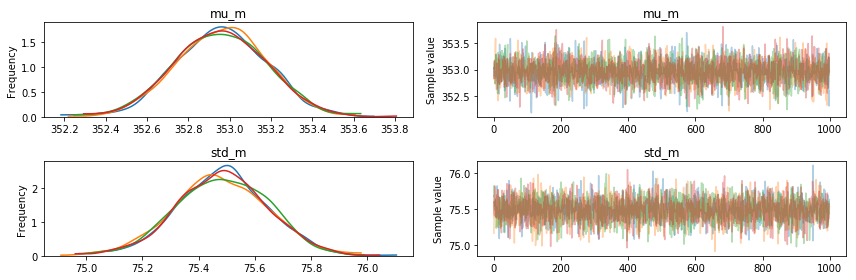

In [12]:
print(pm.summary(m_trace))
pm.traceplot(m_trace)
plt.show()

             mean        sd  mc_error     hpd_2.5    hpd_97.5   n_eff  \
mu_f   316.840454  0.390589  0.006016  316.130708  317.659710  4000.0   
std_f   73.684442  0.273907  0.004397   73.170898   74.220304  3948.0   

           Rhat  
mu_f   1.000237  
std_f  1.000578  


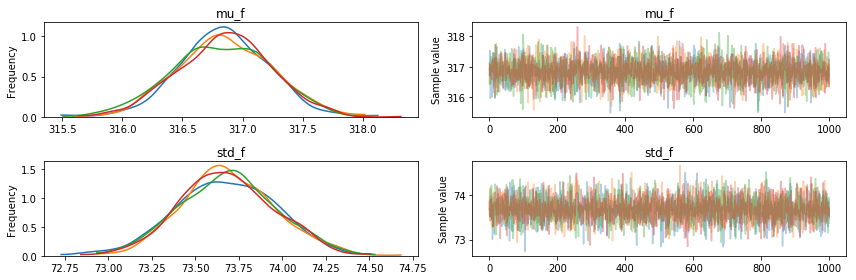

In [13]:
print(pm.summary(f_trace))
pm.traceplot(f_trace)
plt.show()

Let's plot the distributions od the parameters describing the modelled normal distributions for male and female lifters.

In [14]:
mu_m_samples = m_trace['mu_m']
mu_f_samples = f_trace['mu_f']
std_m_samples = m_trace['std_m']
std_f_samples = f_trace['std_f']

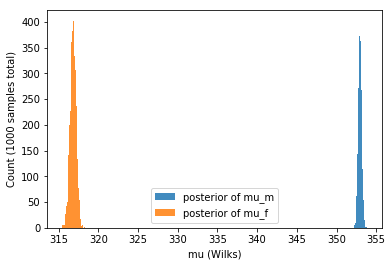

In [15]:
plt.hist(mu_m_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of mu_m")
plt.hist(mu_f_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of mu_f")
plt.legend()
plt.xlabel('mu (Wilks)')
plt.ylabel('Count (1000 samples total)')
plt.show()

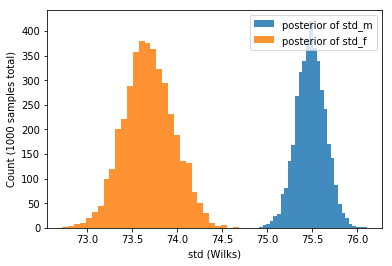

In [16]:
plt.hist(std_m_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of std_m")
plt.hist(std_f_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of std_f")
plt.legend()
plt.xlabel('std (Wilks)')
plt.ylabel('Count (1000 samples total)')
plt.show()

An interesting use of modelling the distributions in this way is that it is possible to generate a set of data using this model, looking at a "what-if" distribution of data that is consistent with the underlying model. Let's write a function to do this, and investigate the results: 

In [17]:
def plot_artificial_wilks(samples):
    m_df = pm.summary(m_trace)
    f_df = pm.summary(f_trace)
    
    mu_m_mu = m_df[m_df.columns[0]].iloc[0]
    mu_m_std = m_df[m_df.columns[1]].iloc[0]
    std_m_mu = m_df[m_df.columns[0]].iloc[1]
    std_m_std = m_df[m_df.columns[1]].iloc[1]
    print(mu_m_mu, mu_m_std, std_m_mu, std_m_std)
    
    mu_f_mu = f_df[f_df.columns[0]].iloc[0]
    mu_f_std = f_df[f_df.columns[1]].iloc[0]
    std_f_mu = f_df[f_df.columns[0]].iloc[1]
    std_f_std = f_df[f_df.columns[1]].iloc[1]
    print(mu_f_mu, mu_f_std, std_f_mu, std_f_std)
    
    m_wilks, f_wilks = np.zeros(samples), np.zeros(samples)
    
    for i in range(samples):
        mu_m = np.random.normal(mu_m_mu, mu_m_std)
        std_m = np.random.normal(std_m_mu, std_m_std)
        #print(mu_m, std_m)
    
        mu_f = np.random.normal(mu_f_mu, mu_f_std)
        std_f = np.random.normal(std_f_mu, std_f_std)
        #print(mu_f, std_f)
        
        m_wilks[i] = np.random.normal(mu_m, std_m)
        f_wilks[i] = np.random.normal(mu_f, std_f)

    plt.hist(m_wilks, histtype='stepfilled', bins=30, alpha=0.85,
             label="male")
    plt.hist(f_wilks, histtype='stepfilled', bins=30, alpha=0.85,
             label="female")
    plt.legend()
    plt.xlabel('Wilks score')
    plt.ylabel('Count ({} samples total)'.format(samples))
    plt.show()

352.95612865 0.222308981077 75.4825515437 0.16128130471
316.840454041 0.390588881934 73.684442091 0.273907392435


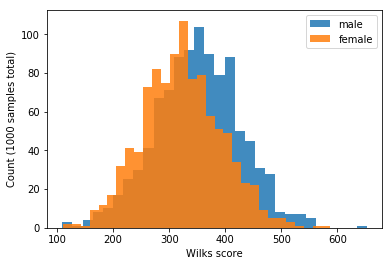

352.95612865 0.222308981077 75.4825515437 0.16128130471
316.840454041 0.390588881934 73.684442091 0.273907392435


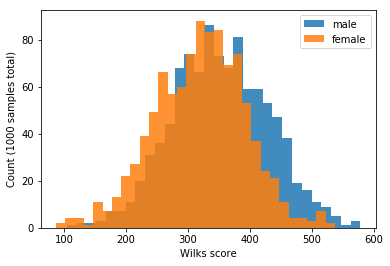

352.95612865 0.222308981077 75.4825515437 0.16128130471
316.840454041 0.390588881934 73.684442091 0.273907392435


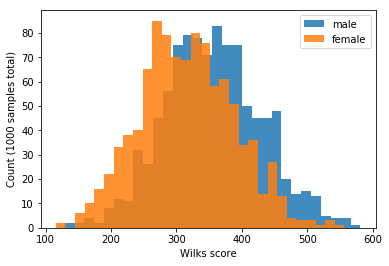

352.95612865 0.222308981077 75.4825515437 0.16128130471
316.840454041 0.390588881934 73.684442091 0.273907392435


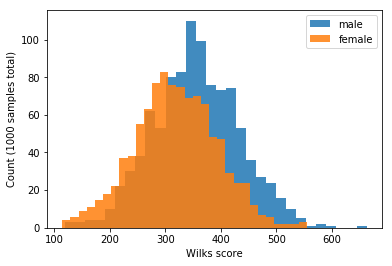

352.95612865 0.222308981077 75.4825515437 0.16128130471
316.840454041 0.390588881934 73.684442091 0.273907392435


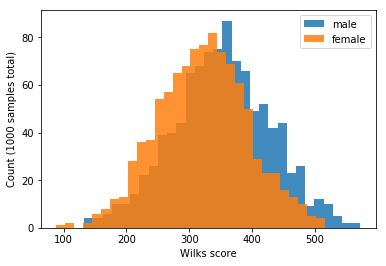

In [18]:
for i in range(5):
    plot_artificial_wilks(1000)

For every set of data we have generated, it looks like the male lifters have a higher mean wilks score than the female lifters.

Now let's try looking at only a subset of the top lifters, to do a similar Bayseian analysis to test the argument that Wilks is fair for the best lifters.

In [19]:
sorted_men = df[df.Sex == 'M'].sort_values('Wilks', ascending=False)
sorted_women = df[df.Sex == 'F'].sort_values('Wilks', ascending=False)

There is an immediate problem: we don't know what distribution to use to model the top lifters distribution off the bat. We know that the normal distribution is a good model for the whole dataset, but for the small upper end (tail of the normal distribution) the choice is less clear. Let's try a half normal distribution to start:

In [20]:
def top_lifters_halfnorm_plot(n):
    # half normal distribution
    t_m_wilks = sorted_men.iloc[:n].Wilks.values
    t_f_wilks = sorted_women.iloc[:n].Wilks.values
    t_wilks = np.concatenate((t_m_wilks, t_f_wilks))
    lower_bound = np.min(t_wilks)
    h_norm = stats.halfnorm
    x = np.linspace(np.min(t_wilks), np.max(t_wilks), 1000)
    y = h_norm.pdf(x, lower_bound, scale=np.std(t_wilks))
    plt.hist(t_wilks, normed=True)
    plt.plot(x, y)
    plt.show()

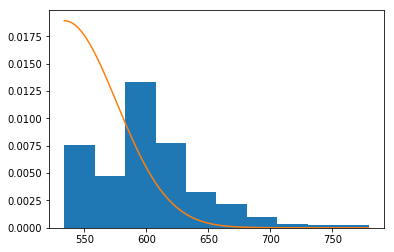

In [21]:
top_lifters_halfnorm_plot(1000)

Just from visual comparison, we can see this isn't a very good model... A better choice may be a generalized Pareto distribution.

In [86]:
def top_lifters_pareto_plot(n):
    t_m_wilks = sorted_men.iloc[:n].Wilks.values
    t_f_wilks = sorted_women.iloc[:n].Wilks.values
    t_wilks = np.concatenate((t_m_wilks, t_f_wilks))
    lower_bound = np.min(t_wilks)
    h_par = stats.pareto
    x = np.linspace(np.min(t_wilks), np.max(t_wilks), 1000)
    y = h_par.pdf(x, b=1, loc=lower_bound-np.std(t_wilks), scale=np.std(t_wilks))
    plt.hist(t_wilks, normed=True, bins=40)
    plt.plot(x, y)
    plt.show()

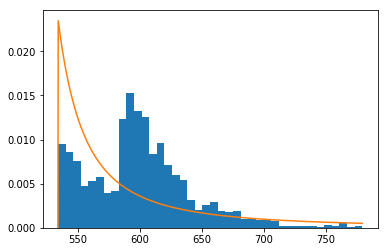

In [91]:
top_lifters_pareto_plot(1000)

Again, this model is not a good fit - there is an interesting spike in the histogram at around 600 Wilks. One interpretation of our failure to find a good distribution for these toip lifters is that the results are skewed by a few meets for world class lifters with more or less competitors, leading to bimodal distributions in the top end. We may have to analyze top lifters meet by meet to investigate further...